In [1]:
%matplotlib inline

In [2]:
import math
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import scipy.ndimage
import scipy.spatial.distance

# Load image, convert to 2D array (1D list of RGB triples)

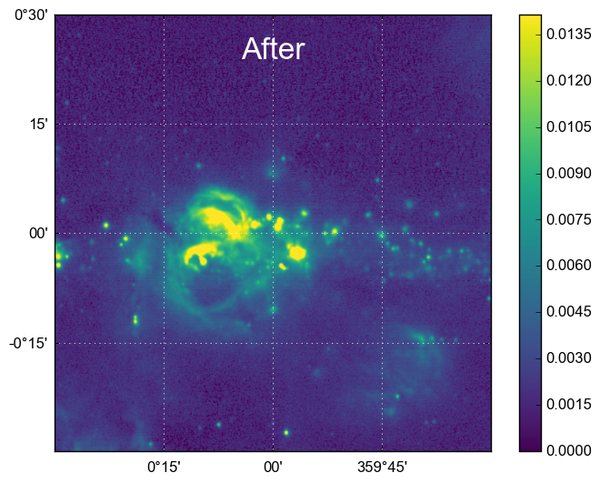

In [3]:
image_obj = Image.open('viridis.png')
image_obj

In [4]:
image = np.asarray(image_obj, dtype=np.uint8)
orig_shape = image.shape
print(orig_shape)
assert len(orig_shape) == 3
assert orig_shape[2] in (3, 4)
image = image.reshape(orig_shape[0] * orig_shape[1], orig_shape[2])[:, :3]
print(image.shape)

(483, 600, 4)
(289800, 3)


# Get 3D histogram

The histogram gives the frequency of each color (RGB triple). If the frequent colors are the ones from a colormap, we are probably using that colormap.

In [5]:
BINS = 32

In [6]:
# Construct the bins
edges = np.repeat((np.arange(BINS + 1, dtype=np.uint8) * 256 / BINS).reshape((1, BINS + 1)), 3, axis=0)

In [7]:
histogram, _ = np.histogramdd(image, bins=edges)
histogram /= image.shape[0]
histogram.shape

(32, 32, 32)

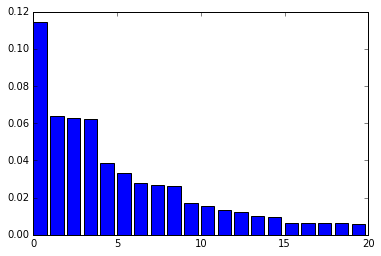

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
max_bins = np.sort(histogram.flatten())[::-1]
plt.bar(np.arange(20), max_bins[1:21])
None

In [9]:
(max_bins > 0.005).sum()

26

# Build test array

This colormap-dependent array will be multiplicated with the histogram to get a "score" of how close it is to that colormap. It basically has positive values on colors close to the colormap, and negative values elsewhere. White is also accepted (value=0) since it is the usual background color.

In [10]:
import matplotlib.cm

colormap = matplotlib.cm.get_cmap('viridis')

In [11]:
# These are all the colors in the colormap
colors = colormap(np.linspace(0.0, 1.0, 1000))[:, :3]
colors = (colors * 255.0).astype(np.uint8)
colors

array([[ 68,   1,  84],
       [ 68,   1,  84],
       [ 68,   1,  84],
       ..., 
       [253, 231,  36],
       [253, 231,  36],
       [253, 231,  36]], dtype=uint8)

In [12]:
colors.shape

(1000, 3)

In [13]:
Image.fromarray(np.repeat([colors], 20, axis=0))

In [14]:
hist, _ = np.histogramdd(colors, bins=edges, normed=False)
hist.shape

(32, 32, 32)

In [15]:
DISTANCE = 2

In [16]:
convo = np.ones((DISTANCE * 2,) * 3, dtype=np.int)

In [17]:
# Reject everything (-4)
testarray = -4 * np.ones(histogram.shape, dtype=np.int)

In [18]:
# Recognize the colors (set them to +1)
recog = scipy.ndimage.filters.convolve(hist, convo, mode='constant', origin=(0, 0, 0))
recog = recog != 0
testarray += recog * 5

In [19]:
# Ignore white (set to 0)
testarray[-DISTANCE:, -DISTANCE:, -DISTANCE:] = 0

# Test colormap

In [20]:
testarray.shape, histogram.shape

((32, 32, 32), (32, 32, 32))

In [21]:
np.dot(testarray.flatten(), histogram.flatten())

0.48782953761214654

## Distance: 2, Bins: 32

| Colormap | Image       | Score    |
|----------|-------------|----------|
| Jet      | jet.png     | +0.48493 |
| Jet      | viridis.png | -2.86535 |
| Jet      | jet-in.png  | +0.92950 |
| Jet      | viri-in.png | -4.00000 |
| Jet      | random.jpg  | -3.46682 |
| Viridis  | jet.png     | -2.86033 |
| Viridis  | viridis.png | +0.48783 |
| Viridis  | jet-in.png  | -3.99625 |
| Viridis  | viri-in.png | +0.93373 |
| Viridis  | random.jpg  | -3.46855 |

# Debug

Build an image with score of individual pixels

In [22]:
min_dist = np.sqrt(scipy.spatial.distance.cdist(image, colors, 'sqeuclidean').min(axis=1))

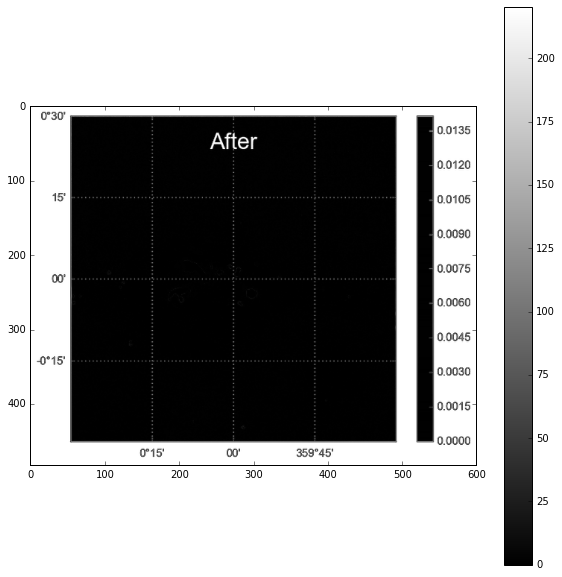

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.imshow(min_dist.reshape(orig_shape[:2]), cmap='gray')
plt.colorbar()
None

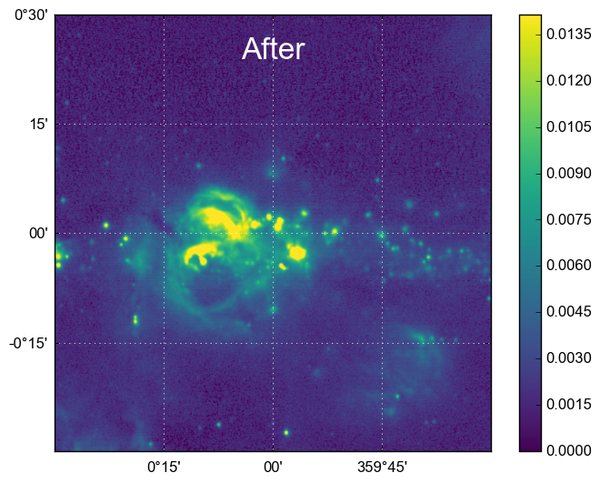

In [24]:
image_obj

# Andy's version, using Kernel Density Estimation (via sklearn)

In [25]:
from sklearn.neighbors import KernelDensity

In [26]:
kde_testarray = colormap(np.linspace(0.0, 1.0, 100))[:, :3]

In [27]:
# subsample
indices = np.random.choice(len(image), size=min(len(image), 2000), replace=False)

In [28]:
# build kde estimate
kde = KernelDensity(bandwidth=0.1).fit((image / 255.0)[indices])

In [29]:
score = kde.score(kde_testarray)
score, score >= -150

(87.998815148579183, True)

| Colormap | Image       | Score    |
|----------|-------------|----------|
| Jet      | jet.png     | - 15.691 |
| Jet      | viridis.png | -976.051 |
| Jet      | jet-in.png  | - 40.748 |
| Jet      | viri-in.png | -991.921 |
| Jet      | random.jpg  | -752.254 |
| Viridis  | jet.png     | -339.984 |
| Viridis  | viridis.png | + 87.999 |
| Viridis  | jet-in.png  | -622.907 |
| Viridis  | viri-in.png | +152.986 |
| Viridis  | random.jpg  | -197.687 |

Threshold set to `-150`.

# Detect heatmaps

This is more involved than what is done above (counting occupied bins, to ensure many different colors are used).

We can also extracts the colormap from an image for evaluation.

In [30]:
from colorspacious import cspace_convert
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics import euclidean_distances
import scipy.sparse as sp

def is_heatmap(image, threshold=1, random_seed=None):
    # drop alpha channel
    if image.shape[2] == 4:
        image = image[:, :, :3]
    # convert to cam space
    flat = image.reshape(-1, 3)
    # subsample for speed
    state = np.random.RandomState(random_seed)
    indices = state.choice(len(flat), size=2000, replace=False)
    subsample_rgb = flat[indices]
    subsample = cspace_convert(subsample_rgb, "sRGB255", "CAM02-UCS")

    # compute MST
    distances = euclidean_distances(subsample)
    mst = sp.csgraph.minimum_spanning_tree(distances)
    connectivity = (mst + mst.T != 0).astype(np.int)
    
    # prune leaves until only a chain is left:
    last_n_nodes = connectivity.shape[0]
    central_nodes = np.arange(last_n_nodes)
    while True:
        not_leaf, = np.where(np.array(connectivity.sum(axis=0)).ravel() > 1)
        central_nodes = central_nodes[not_leaf]
        connectivity = connectivity[not_leaf, :][:, not_leaf]
        if connectivity.shape[0] >= last_n_nodes - 2:
            break
        last_n_nodes = connectivity.shape[0]
    # central nodes contain the chain
    chain = subsample[central_nodes]
    print("length of chain: %d" % len(central_nodes))
    if len(central_nodes) < 100:
        print("probably an illustration / vectorgraphic")
        # hack to return false on is_heatmap
        threshold = -1
    # now get the order along the chain:
    # find one of the two leaves
    leafs, = np.where(np.array(connectivity.sum(axis=0)).ravel() == 1)
    chain_order, _ = sp.csgraph.depth_first_order(connectivity, leafs[0])
    # chain order reorders central_nodes. get indices in original subsample array
    ordered_chain = central_nodes[chain_order]
    
    # check if the chain covers most of the colors:
    # median was meh (a sunset fooled us), let's try l1
    distance_to_chain = np.abs(np.min(euclidean_distances(subsample, chain), axis=1)).mean()
    print(distance_to_chain)
    return distance_to_chain < threshold, ordered_chain, subsample, subsample_rgb

length of chain: 284
13.9399754015


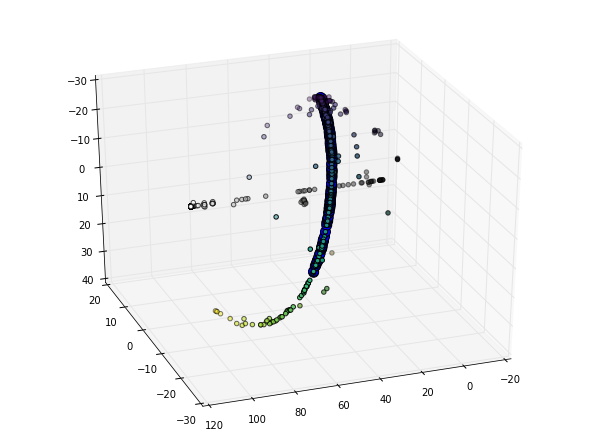

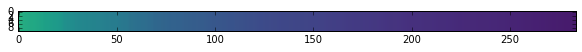

In [31]:
decision, chain_order, subsample, subsample_rgb = is_heatmap(image.reshape(orig_shape[:2] + (-1,)), random_seed=5)
from mpl_toolkits.mplot3d import Axes3D

# 3d plot in cam space
X_ = subsample[chain_order]
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_[:, 0], X_[:, 1], X_[:, 2], s=100)
ax.scatter(subsample[:, 0], subsample[:, 1], subsample[:, 2], c=subsample_rgb/255.)


# extracted colormap
plt.figure()
plt.imshow(np.repeat(subsample_rgb[chain_order].reshape(1, -1, 3), repeats=10, axis=0))
plt.show()